In [47]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.pyplot import MultipleLocator
import seaborn as sns; sns.set()
sns.__version__

'0.11.1'

In [48]:
sns.set_style("ticks", {"xtick.major.size":15,"ytick.major.size":15})

plt.rc('font', family='Helvetica')
plt.rcParams['pdf.fonttype'] = 42

%config InlineBackend.figure_format = 'retina'

In [3]:
df_pair_1985_2009 = pd.read_pickle("/data/interdisciplinarity/df_pair_1985_2009.pkl")
df_paper_1985_2009 = pd.read_pickle("/data/interdisciplinarity/df_paper_1985_2009.pkl")
df_grant_1985_2009 = pd.read_pickle("/data/interdisciplinarity/df_grant_1985_2009.pkl")

In [4]:
# Source: http://www.cookbook-r.com/Graphs/Plotting_means_and_error_bars_%28ggplot2%29/
# Produces count, mean, standard deviation, standard error of the mean, and confidence interval (default 95%).
##   data: a data frame
##   measurevar: the name of a column that contains the variable to be summariezed
##   groupvars: a vector containing names of columns that contain grouping variables
##   conf_interval: the percent range of the confidence interval (default is 95%)

import scipy as sp
from scipy.stats import t

def summarySE(data, measurevar, groupvars, conf_interval=0.95):
    def std(s):
        return np.std(s, ddof=1)
    def stde(s):
        return std(s) / np.sqrt(len(s))
    def ci(s):
        # Confidence interval multiplier for standard error
        # Calculate t-statistic for confidence interval: 
        # e.g., if conf.interval is .95, use .975 (above/below), and use df=N-1
        ciMult = t.ppf(conf_interval/2.0 + .5, len(s)-1)
        return stde(s)*ciMult
    def ciUpper(s):
        return np.mean(s)+ci(s)
    def ciLower(s):
        return np.mean(s)-ci(s)
    
    data = data[groupvars+measurevar].groupby(groupvars).agg([len, np.mean, std, stde, ciUpper, ciLower, ci])

    data.reset_index(inplace=True)

    data.columns = groupvars+['_'.join(col).strip() for col in data.columns.values[len(groupvars):]]

    return data

In [5]:
#####----- A -----#####
paperITD_per_year = summarySE(df_paper_1985_2009, ['interdisciplinarity_reference'], ['pub_year'])
paperITD_per_year_grant = summarySE(df_paper_1985_2009, ['interdisciplinarity_reference'],
                                    ['grant_status','pub_year'])

In [6]:
#####----- B -----#####
df_tmp = df_pair_1985_2009[['interdisciplinarity_reference','interdisciplinarity_citation','grant_interdisciplinarity_interval']]
paperRefITD_per_grantITD = summarySE(df_tmp, ['interdisciplinarity_reference'], ['grant_interdisciplinarity_interval'])
paperCitITD_per_grantITD = summarySE(df_tmp, ['interdisciplinarity_citation'], ['grant_interdisciplinarity_interval'])

In [7]:
#####----- C -----#####
hitRate_per_paperITD = summarySE(df_paper_1985_2009, ['c_hit_rate_5_lvl-0'], ['interdisciplinarity_reference_interval'])
hitRate_per_paperITD_grant = summarySE(df_paper_1985_2009, ['c_hit_rate_5_lvl-0'],
                                       ['grant_status','interdisciplinarity_reference_interval'])

In [58]:
#####----- D -----#####
"""
numPaper_per_grantITD = df_grant_1985_2009[['grant_interdisciplinarity_percentile',
                                            'grant_id','num_paper']].drop_duplicates()
numPaper_per_grantITD['grant_interdisciplinarity_percentile'] = numPaper_per_grantITD['grant_interdisciplinarity_percentile'].apply(lambda x: x*100)
"""
df_tmp = df_grant_1985_2009[['grant_id','grant_interdisciplinarity_interval','num_paper']].drop_duplicates()
numPaper_per_grantITD = summarySE(df_tmp, ['num_paper'], ['grant_interdisciplinarity_interval'])

In [9]:
#####----- E -----#####
df_tmp = df_pair_1985_2009[['grant_interdisciplinarity_interval','c_hit_rate_5_lvl-0','interdisciplinarity_reference_interval_5']]
hitRate_per_grantITD = summarySE(df_tmp, ['c_hit_rate_5_lvl-0'], ['grant_interdisciplinarity_interval'])

<ipython-input-60-4d8eacc65713>:174: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


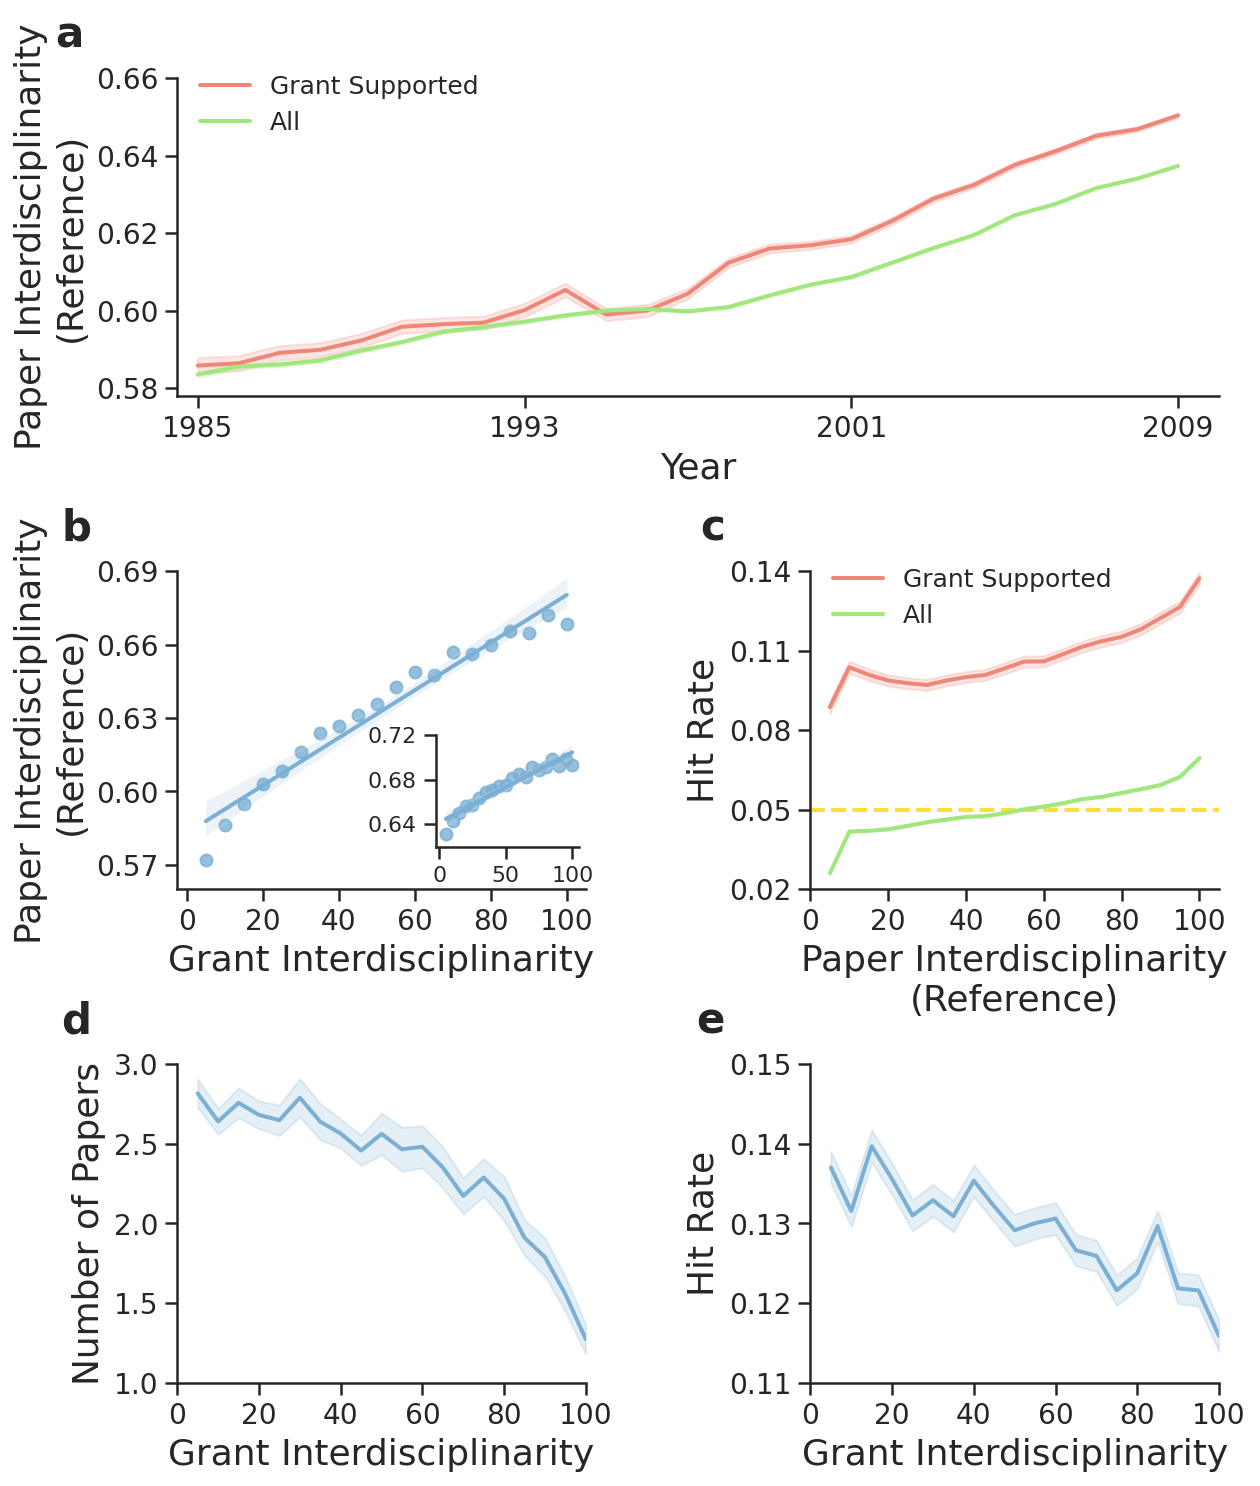

In [60]:
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
matplotlib.rcParams['agg.path.chunksize'] = 10000

fig = plt.figure(figsize=(14*(2/3),4*3))
gs = GridSpec(3, 2, figure=fig)
gs.update(wspace=0.55, hspace=0.55)

#####----- A -----#####
ax = fig.add_subplot(gs[0,0:2])
c1,c2 = '#ef8677','#a0e77d'

x1 = paperITD_per_year['pub_year']
mu1 = paperITD_per_year['interdisciplinarity_reference_mean']
ci1 = paperITD_per_year['interdisciplinarity_reference_ci']
x2 = paperITD_per_year_grant[paperITD_per_year_grant['grant_status']==1]['pub_year']
mu2 = paperITD_per_year_grant[paperITD_per_year_grant['grant_status']==1]['interdisciplinarity_reference_mean']
ci2 = paperITD_per_year_grant[paperITD_per_year_grant['grant_status']==1]['interdisciplinarity_reference_ci']

ax.plot(x2, mu2, lw=2, label='Grant Supported', color=c1)
ax.plot(x1, mu1, lw=2, label='All', color=c2)
ax.fill_between(x2, mu2+ci2, mu2-ci2, facecolor='C0', alpha=0.2, color=c1)
ax.fill_between(x1, mu1+ci1, mu1-ci1, facecolor='C2', alpha=0.2, color=c2)

ax.set_xlabel('Year', fontsize=18)
ax.set_ylabel('Paper Interdisciplinarity\n(Reference)', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.gca().yaxis.set_major_locator(MultipleLocator(0.02))
plt.ylim(0.578, 0.66)
plt.xticks([1985, 1993, 2001, 2009])
ax.set_xticklabels(['1985', '1993', '2001', '2009'])
plt.xlim(1984.5, 2010)

ax.legend(loc='lower left', bbox_to_anchor=(0.0, 0.75),
          fontsize=12.5, frameon=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-0.09, 1.2, 'a', transform=ax.transAxes,
        fontsize=21, fontweight='bold', va='top', ha='right')



#####----- B -----#####
ax = fig.add_subplot(gs[1,0])

ax = sns.regplot(ax=ax, x='grant_interdisciplinarity_interval', y='interdisciplinarity_reference_mean',
                 line_kws={'linewidth':2}, color='#7bafd4', data=paperRefITD_per_grantITD)
ax.set_ylabel('Paper Interdisciplinarity\n(Reference)', fontsize=18)
ax.set_xlabel('Grant Interdisciplinarity', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)

plt.gca().yaxis.set_major_locator(MultipleLocator(0.03))
plt.ylim(0.56, 0.69)
plt.gca().xaxis.set_major_locator(MultipleLocator(20))
plt.xlim(-2.5, 105)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Create an inset in the lower right corner (loc=4) with borderpad=1, i.e.,
# 10 points padding (as 10pt is the default fontsize) to the parent axes.
axins = inset_axes(ax, width="35%", height="35%", loc=4, 
                   bbox_to_anchor=(0.01,0.1,1,1), bbox_transform=ax.transAxes)
axins = sns.regplot(ax=axins, x='grant_interdisciplinarity_interval', y='interdisciplinarity_citation_mean', 
                    line_kws={'linewidth':2}, color='#7bafd4', data=paperCitITD_per_grantITD)
axins.set_ylabel('')
axins.set_xlabel('')

plt.gca().yaxis.set_major_locator(MultipleLocator(0.04))
plt.ylim(0.62, 0.72)
plt.gca().xaxis.set_major_locator(MultipleLocator(50))
plt.xlim(-2.5, 105)
    
axins.spines['top'].set_visible(False)
axins.spines['right'].set_visible(False)
ax.text(-0.21, 1.2, 'b', transform=ax.transAxes,
        fontsize=21, fontweight='bold', va='top', ha='right')



#####----- C -----#####
ax = fig.add_subplot(gs[1,1])

c1,c2 = '#ef8677','#a0e77d'

x1 = hitRate_per_paperITD['interdisciplinarity_reference_interval']
mu1 = hitRate_per_paperITD['c_hit_rate_5_lvl-0_mean']
ci1 = hitRate_per_paperITD['c_hit_rate_5_lvl-0_ci']
x2 = hitRate_per_paperITD_grant[hitRate_per_paperITD_grant['grant_status']==1]['interdisciplinarity_reference_interval']
mu2 = hitRate_per_paperITD_grant[hitRate_per_paperITD_grant['grant_status']==1]['c_hit_rate_5_lvl-0_mean']
ci2 = hitRate_per_paperITD_grant[hitRate_per_paperITD_grant['grant_status']==1]['c_hit_rate_5_lvl-0_ci']

ax.plot(x2, mu2, lw=2, label='Grant Supported', color=c1)
ax.plot(x1, mu1, lw=2, label='All', color=c2)
ax.fill_between(x2, mu2+ci2, mu2-ci2, facecolor='C0', alpha=0.2, color=c1)
ax.fill_between(x1, mu1+ci1, mu1-ci1, facecolor='C2', alpha=0.2, color=c2)

ax.set_xlabel('Paper Interdisciplinarity\n(Reference)', fontsize=18)
ax.set_ylabel('Hit Rate', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.gca().xaxis.set_major_locator(MultipleLocator(20))
plt.xlim(0, 105)
plt.yticks([0.02, 0.05, 0.08, 0.11, 0.14])
ax.set_yticklabels(['0.02', '0.05', '0.08', '0.11', '0.14'])
plt.ylim(0.02, 0.14)

ax.axhline(0.05, linestyle='--', color='#FFD700', alpha=0.8, zorder=0, lw=2)

ax.legend(loc='lower left', bbox_to_anchor=(0.0, 0.75),
          fontsize=12.5, frameon=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-0.21, 1.2, 'c', transform=ax.transAxes,
        fontsize=21, fontweight='bold', va='top', ha='right')



#####----- D -----#####
ax = fig.add_subplot(gs[2,0])

x = numPaper_per_grantITD['grant_interdisciplinarity_interval']
mu = numPaper_per_grantITD['num_paper_mean']
ci = numPaper_per_grantITD['num_paper_ci']

ax.plot(x, mu, lw=2, color='#7bafd4')
ax.fill_between(x, mu+ci, mu-ci, alpha=0.2, color='#7bafd4')

plt.gca().yaxis.set_major_locator(MultipleLocator(0.5))
plt.ylim(1.0, 3.0)
plt.gca().xaxis.set_major_locator(MultipleLocator(20))
plt.xlim(0, 100)

ax.set_ylabel('Number of Papers', fontsize=18)
ax.set_xlabel('Grant Interdisciplinarity', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-0.21, 1.2, 'd', transform=ax.transAxes,
        fontsize=21, fontweight='bold', va='top', ha='right')



#####----- E -----#####
ax = fig.add_subplot(gs[2,1])

x = hitRate_per_grantITD['grant_interdisciplinarity_interval']
mu = hitRate_per_grantITD['c_hit_rate_5_lvl-0_mean']
ci = hitRate_per_grantITD['c_hit_rate_5_lvl-0_ci']

ax.plot(x, mu, lw=2, color='#7bafd4')
ax.fill_between(x, mu+ci, mu-ci, alpha=0.2, color='#7bafd4')

plt.yticks([0.11, 0.12, 0.13, 0.14, 0.15])
ax.set_yticklabels(['0.11', '0.12', '0.13', '0.14', '0.15'])
plt.ylim(0.11, 0.15)
plt.gca().xaxis.set_major_locator(MultipleLocator(20))
plt.xlim(0, 100)

ax.set_ylabel('Hit Rate', fontsize=18)
ax.set_xlabel('Grant Interdisciplinarity', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-0.21, 1.2, 'e', transform=ax.transAxes,
        fontsize=21, fontweight='bold', va='top', ha='right')



#####-------------#####
plt.tight_layout()
plt.show()

fig.savefig('./fig/fig-2.pdf', format='pdf', dpi=700, bbox_inches='tight')